In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop
import tensorflow as tf
from ipynb.fs.full.plotter_class import Plotter
from ipynb.fs.full.time_series_data import TimeSeriesData

In [2]:
data_path = './../data'
file_name = 'weather_dataset_preprocesado.csv'
ts_data = TimeSeriesData(data_path, file_name)
series = ts_data.df['T (degC)']

In [3]:
train, val, test = ts_data.train_val_test_split(series)

print(f'Tamaño set de entrenamiento: {train.shape}')
print(f'Tamaño set de validación: {val.shape}')
print(f'Tamaño set de prueba: {test.shape}')

Tamaño set de entrenamiento: (40179,)
Tamaño set de validación: (5022,)
Tamaño set de prueba: (5023,)


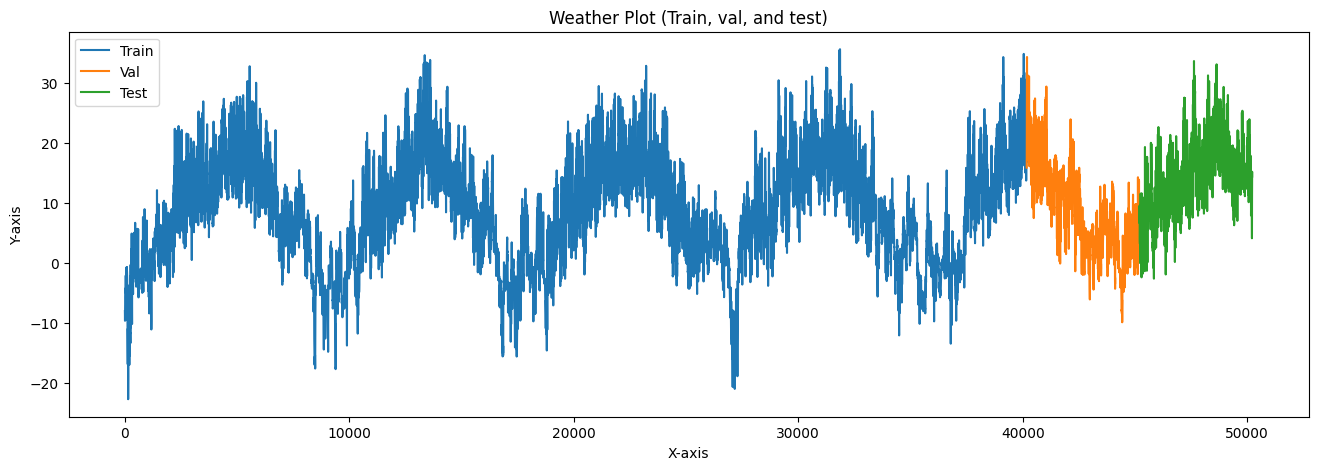

In [4]:
plotter = Plotter()

plotter.plot(train, label='Train')
plotter.plot(val, label='Val')
plotter.plot(test, label='Test')
plotter.configure(title='Weather Plot (Train, val, and test)', xlabel='X-axis', ylabel='Y-axis')
plotter.show()

In [5]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
# INPUT_LENGTH = 48    # Posteriormente afinaremos este hiperparámetro
INPUT_LENGTH = 24    # Posteriormente afinaremos este hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

In [6]:
from ipynb.fs.full.dataset_creator import SupervisedDatasetCreator
from ipynb.fs.full.dataset_scaler import DatasetScaler
from ipynb.fs.full.dataset_scaler_manager import DataScalerManager
from ipynb.fs.full.lstm import LSTMModel

In [7]:
preprocessor = SupervisedDatasetCreator(INPUT_LENGTH, OUTPUT_LENGTH)
x_train, y_train = preprocessor.create_supervised_dataset(train.values)
x_val, y_val = preprocessor.create_supervised_dataset(val.values)
x_test, y_test = preprocessor.create_supervised_dataset(test.values)

In [8]:
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento    \t x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'Set de validación       \t x_val: {x_val.shape}, y_val: {y_val.shape}')
print(f'Set de prueba           \t x_test: {x_test.shape}, y_test: {y_test.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento    	 x_train: (40154, 24, 1), y_train: (40154, 1, 1)
Set de validación       	 x_val: (4997, 24, 1), y_val: (4997, 1, 1)
Set de prueba           	 x_test: (4998, 24, 1), y_test: (4998, 1, 1)


In [9]:
data_scaler_manager = DataScalerManager()

data_in = {
    'x_train': x_train, 'y_train': y_train,
    'x_val': x_val, 'y_val': y_val,
    'x_test': x_test, 'y_test': y_test,
}

scaled_data = data_scaler_manager.scale_data(data_in)
data_scaler_manager.print_min_max(data_in, scaled_data)

Min x_train without scaling: -22.76
Min x_train with scaling: -1.0
Max x_train without scaling: 35.65
Max x_train with scaling: 1.0000000000000002 

Min y_train without scaling: -22.76
Min y_train with scaling: -1.0
Max y_train without scaling: 35.65
Max y_train with scaling: 1.0000000000000002 

Min x_val without scaling: -9.92
Min x_val with scaling: -0.5603492552645094
Max x_val without scaling: 34.34
Max x_val with scaling: 0.9551446670090742 

Min y_val without scaling: -9.92
Min y_val with scaling: -0.5603492552645094
Max y_val without scaling: 31.33
Max y_val with scaling: 0.8520801232665642 

Min x_test without scaling: -2.64
Min x_test with scaling: -0.31107687039890414
Max x_test without scaling: 33.68
Max x_test with scaling: 0.932545796952577 

Min y_test without scaling: -2.64
Min y_test with scaling: -0.31107687039890414
Max y_test without scaling: 33.68
Max y_test with scaling: 0.932545796952577 



In [10]:
x_train_s, y_train_s = scaled_data['x_train'], scaled_data['y_train']
x_val_s, y_val_s = scaled_data['x_val'], scaled_data['y_val']
x_test_s, y_test_s = scaled_data['x_test'], scaled_data['y_test']

In [11]:
# Define model parameters
n_units = 128  # Number of LSTM units
input_shape = (x_train_s.shape[1], x_train_s.shape[2])  # Shape of the input data

In [12]:
# lstm_model = LSTMModel(n_units=n_units, input_shape=input_shape)
lstm_model = LSTMModel(n_units=n_units, input_shape=input_shape, learning_rate=1e-4)

model = lstm_model.model

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
epochs = 50
batch_size = 128
# batch_size = 256

In [14]:
# history = model.fit(x_train_s,
#     y_train_s,
#     epochs=epochs, 
#     batch_size=batch_size,
#     validation_data = (x_val_s, y_val_s),
#     verbose=2)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    x_train_s, y_train_s, epochs=epochs, batch_size=batch_size,
    validation_data=(x_val_s, y_val_s), verbose=2,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
314/314 - 26s - 82ms/step - loss: 0.1272 - val_loss: 0.0653 - learning_rate: 1.0000e-04
Epoch 2/50
314/314 - 22s - 70ms/step - loss: 0.0697 - val_loss: 0.0547 - learning_rate: 1.0000e-04
Epoch 3/50
314/314 - 23s - 74ms/step - loss: 0.0601 - val_loss: 0.0489 - learning_rate: 1.0000e-04
Epoch 4/50
314/314 - 22s - 71ms/step - loss: 0.0546 - val_loss: 0.0447 - learning_rate: 1.0000e-04
Epoch 5/50
314/314 - 22s - 71ms/step - loss: 0.0502 - val_loss: 0.0410 - learning_rate: 1.0000e-04
Epoch 6/50
314/314 - 23s - 72ms/step - loss: 0.0471 - val_loss: 0.0384 - learning_rate: 1.0000e-04
Epoch 7/50
314/314 - 23s - 72ms/step - loss: 0.0437 - val_loss: 0.0344 - learning_rate: 1.0000e-04
Epoch 8/50
314/314 - 23s - 72ms/step - loss: 0.0411 - val_loss: 0.0324 - learning_rate: 1.0000e-04
Epoch 9/50
314/314 - 22s - 71ms/step - loss: 0.0392 - val_loss: 0.0303 - learning_rate: 1.0000e-04
Epoch 10/50
314/314 - 24s - 75ms/step - loss: 0.0376 - val_loss: 0.0285 - learning_rate: 1.0000e-04
Epoch 11/

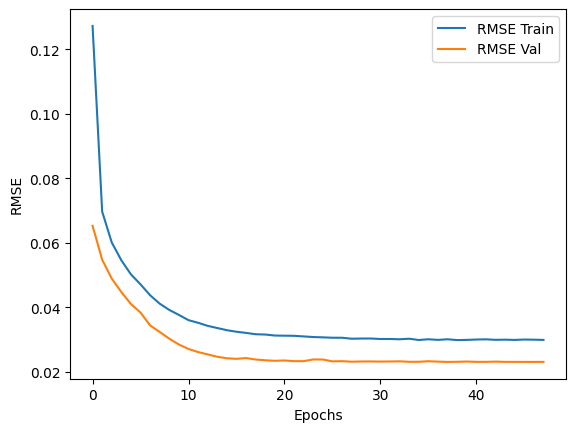

In [17]:
plt.plot(history.history['loss'], label='RMSE Train')
plt.plot(history.history['val_loss'], label='RMSE Val')
plt.xlabel('Epochs')
plt.ylabel('RMSE')

plotter.configure(title='Epochs vs RMSE', xlabel='Epochs', ylabel='RMSE')
plotter.show()